![CDS 411 logo](../../img/cds-411-logo.png)

# Class 19: Monte Carlo simulations II

---

![CC BY-SA 4.0 license](../../img/cc-by-sa.png)

This notebook is licensed under a [Creative Commons Attribution-ShareAlike 4.0 International License](http://creativecommons.org/licenses/by-sa/4.0/).

## Load packages

In [1]:
%matplotlib inline

from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy

np.random.seed(1618027461)

## Monte Carlo integration

In [2]:
import mc_integration

At the end of last class, we were introduced to Monte Carlo integration. We used it to estimate the area under the curve defined by the function $y(x)=-1.75x^2+x^3+1.4$ within the bounds $0\leq{}x\leq{}2.0$ and $0\leq{}y\leq{}2.5$.

In [3]:
x = np.linspace(start=0, stop=2.0, num=200)
df = pd.DataFrame({"x": x, "y": mc_integration.cubic_function(x)})

The function and area to find is visualized below:

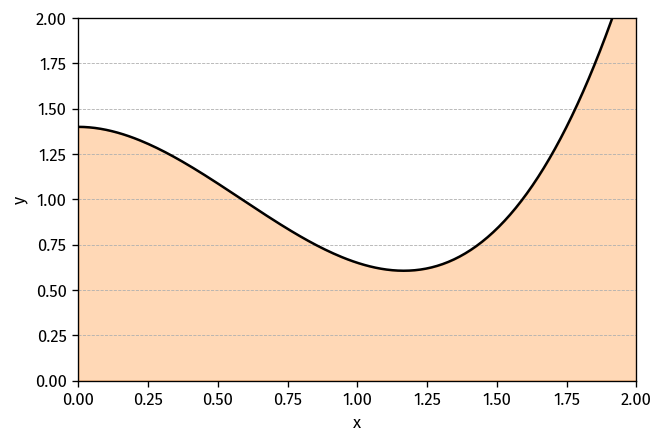

In [4]:
fig, ax = plt.subplots(dpi=120)
sns.lineplot(x="x", y="y", data=df, ax=ax, color="black")
ax.fill_between(x=df["x"], y1=df["y"], color="tab:orange", alpha=0.3)
ax.set_xlim([0, 2.0])
ax.set_ylim([0, 2.0]);

To use a Monte Carlo simulation to calculate the area under the curve, we note that the area under the curve is approximately equal to

\begin{equation}
  \text{area}\approx{}\left(\text{area of enclosing rectangle}\right)\left(\frac{\text{number of darts below}}{\text{number of darts}}\right)
\end{equation}

We implemented functions to compute this quantity, see the supplied file [mc\_integration.py](mc_integration.py). We ran the simulation throwing 1,000 darts within the bounds and used this to compute the area under the curve.

In [5]:
mc_results_df, mc_results_area = mc_integration.run(
    function=mc_integration.cubic_function,
    number_of_darts=1000,
    x_min=0,
    x_max=2,
    y_min=0,
    y_max=2.5
)

Visually, the integration looked as follows:

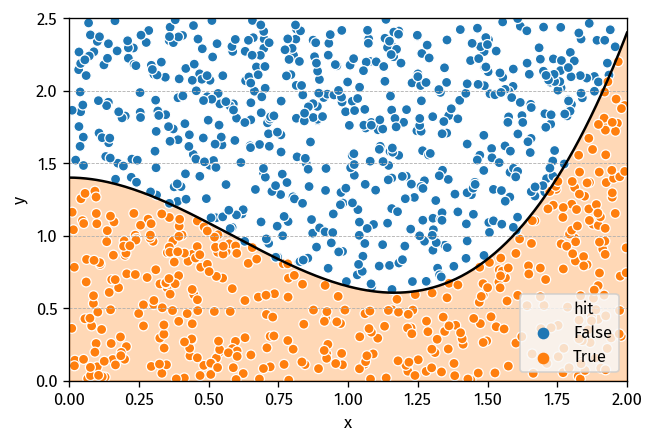

In [6]:
fig, ax = plt.subplots(dpi=120)
sns.lineplot(x="x", y="y", data=df, color="black", ax=ax)
ax.fill_between(x=df["x"], y1=df["y"], color="tab:orange", alpha=0.3)
sns.scatterplot(x="x", y="y", hue="hit", data=mc_results_df, ax=ax)
ax.set_xlim([0, 2.0])
ax.set_ylim([0, 2.5]);

The estimated area is:

In [7]:
print(f"estimated area = {mc_results_area}")

estimated area = 2.145


The exact area is:

In [8]:
exact_area_numerical = scipy.integrate.quad(
    func=mc_integration.cubic_function,
    a=0,
    b=2,
)

print(f"exact area = {exact_area_numerical[0]}")

exact area = 2.1333333333333333


## Statistical variation of estimated area

If we re-run the computation for the estimated area using 1,000 darts, we find that the estimated area is different:

In [9]:
mc_results_df_run2, mc_results_area_run2 = mc_integration.run(
    function=mc_integration.cubic_function,
    number_of_darts=1000,
    x_min=0,
    x_max=2,
    y_min=0,
    y_max=2.5
)
print(f"estimated area = {mc_results_area_run2}")

estimated area = 2.29


This is a common feature of Monte Carlo simulations that is a direct consequence of using a random number generator. Even when all input variables are kept fixed, the numerical result will vary. Thus, we can apply the statistical methods we discussed during the data-driven modeling unit here. How to do this? First, we need a distribution of estimated areas when we perform 1,000 random dart throws. Here's how we'll obtain that:

1.  Initialize a list
2.  Fix the parameters for the `mc_integration.run()` simulation and run it.
3.  Append the estimated area to the list.
4.  Repeat the simulation multiple times, building up a distribution of estimated areas for the same number of random dart throws.

In code, we use a `for` loop to do this:

In [10]:
distribution_estimated_areas = {
    "run": [],
    "area": [],
}

for run in range(1000):
    tmp_df, tmp_estimated_area = mc_integration.run(
        function=mc_integration.cubic_function,
        number_of_darts=1000,
        x_min=0,
        x_max=2,
        y_min=0,
        y_max=2.5
    )
    distribution_estimated_areas["run"].append(run)
    distribution_estimated_areas["area"].append(tmp_estimated_area)

We then convert the list of estimated areas into a data frame:

In [11]:
distribution_estimated_areas_df = pd.DataFrame(distribution_estimated_areas)

Looking at the summary statistics, we get:

In [12]:
distribution_estimated_areas_df["area"].describe()

count    1000.000000
mean        2.133540
std         0.080404
min         1.855000
25%         2.080000
50%         2.135000
75%         2.190000
max         2.355000
Name: area, dtype: float64

Plotting the distribution of areas, we get:

/home/jglasbr2/.conda/envs/cds411-dev/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


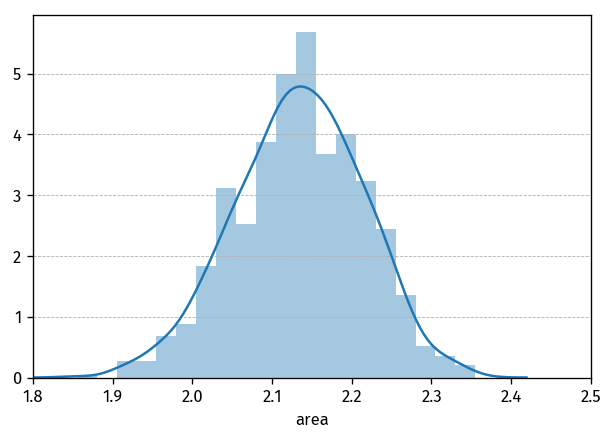

In [13]:
fig, ax = plt.subplots(dpi=120)
sns.distplot(a=distribution_estimated_areas_df["area"], bins=20, ax=ax)
ax.set_xlim([1.8, 2.5]);

Let's use bootstrapping to estimate the standard error for the mean of the distribution:

In [14]:
bootstrap_results = {
    "sample": [],
    "mean": [],
}

bootstrap_series = distribution_estimated_areas_df \
    .sample(frac=1000, replace=True) \
    .loc[:, "area"]
bootstrap_df = pd.DataFrame(bootstrap_series) \
    .assign(sample_id=[f"{x}" for x in range(1000) for _ in range(1000)])
bootstrap_mean_samples = bootstrap_df \
    .groupby(["sample_id"]) \
    .mean() \
    .loc[:, "area"] \
    .values

bootstrap_results["sample"].extend(list(range(1000)))
bootstrap_results["mean"].extend(bootstrap_mean_samples)

estimated_area_bootstrap_df = pd.DataFrame(bootstrap_results)

We'll use the 95% confidence interval to define the lower and upper bounds of the error of the mean:

In [15]:
estimated_areas_ci_95 = estimated_area_bootstrap_df \
    .loc[:, ["mean"]] \
    .quantile([0.025, 0.975]) \
    .reset_index() \
    .rename(columns={"index": "quantile"})

Numerically, the mean is:

In [16]:
distribution_estimated_areas_df["area"].mean()

2.13354

The upper and lower bounds for the error of the mean are:

In [17]:
estimated_areas_ci_95

,quantile,mean
0,0.025,2.128628
1,0.975,2.138330


Visually, we have:

/home/jglasbr2/.conda/envs/cds411-dev/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


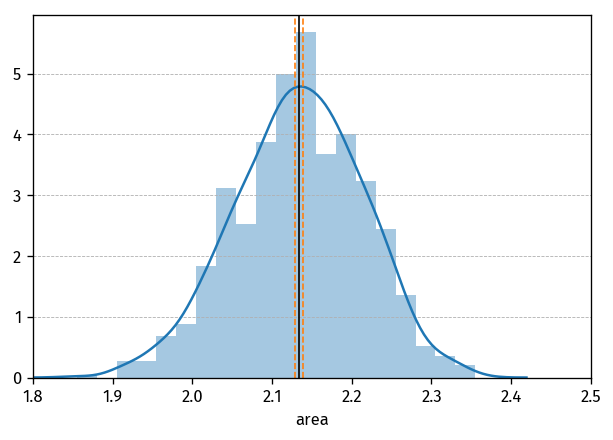

In [18]:
fig, ax = plt.subplots(dpi=120)
sns.distplot(a=distribution_estimated_areas_df["area"], bins=20, ax=ax)
ax.axvline(x=distribution_estimated_areas_df["area"].mean(), color="black", linestyle="-", linewidth=1)
ax.axvline(x=estimated_areas_ci_95.loc[0, "mean"], color="tab:orange", linestyle="--", linewidth=1)
ax.axvline(x=estimated_areas_ci_95.loc[1, "mean"], color="tab:orange", linestyle="--", linewidth=1)
ax.set_xlim([1.8, 2.5]);

## Activity

Using the above code as a starting point, compute the area under the curve for increasing numbers of dart throws, starting from 1000 up until one million in powers of 10. So, 1,000, 10,000, 100,000, and 1,000,000. For each case, do the following:

1.  For a fixed number of dart throws, run the simulation 1000 times and obtain the distribution of estimated areas.
2.  Create histograms that summarize the range of outcomes for each amount of dart throws.
3.  Use bootstrapping to compute the standard error of the mean for each number of dart throws.

### Activity work

Define functions to simplify how we run our simulations for different numbers of darts.

In [19]:
def multi_integration_sims(number_of_darts):

    distribution_estimated_areas = {
        "run": [],
        "area": [],
    }
    
    for run in range(1000):
        tmp_df, tmp_estimated_area = mc_integration.run(
            function=mc_integration.cubic_function,
            number_of_darts=number_of_darts,
            x_min=0,
            x_max=2,
            y_min=0,
            y_max=2.5
        )
        distribution_estimated_areas["run"].append(run)
        distribution_estimated_areas["area"].append(tmp_estimated_area)
    
    return pd.DataFrame(distribution_estimated_areas)

In [20]:
def darts_bootstrap(df):
    bootstrap_results = {
        "sample": [],
        "mean": [],
    }
    
    bootstrap_series = df \
        .sample(frac=1000, replace=True) \
        .loc[:, "area"]
    bootstrap_df = pd.DataFrame(bootstrap_series) \
        .assign(sample_id=[f"{x}" for x in range(1000) for _ in range(1000)])
    bootstrap_mean_samples = bootstrap_df \
        .groupby(["sample_id"]) \
        .mean() \
        .loc[:, "area"] \
        .values
    
    bootstrap_results["sample"].extend(list(range(1000)))
    bootstrap_results["mean"].extend(bootstrap_mean_samples)
    
    return pd.DataFrame(bootstrap_results)

In [21]:
def confidence_intervals(df):

    return df \
        .loc[:, ["mean"]] \
        .quantile([0.025, 0.975]) \
        .reset_index() \
        .rename(columns={"index": "quantile"})

Create a dictionary to store our results

In [22]:
activity_results = {
    "num_darts": [],
    "mean": [],
    "ci95_lower": [],
    "ci95_upper": [],
}

#### 100 darts

In [23]:
results_df = multi_integration_sims(100)
bootstrap_df = darts_bootstrap(results_df)
ci_df = confidence_intervals(bootstrap_df)

activity_results["num_darts"].append(100)
activity_results["mean"].append(results_df["area"].mean())
activity_results["ci95_lower"].append(ci_df.loc[0, "mean"])
activity_results["ci95_upper"].append(ci_df.loc[1, "mean"])

/home/jglasbr2/.conda/envs/cds411-dev/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


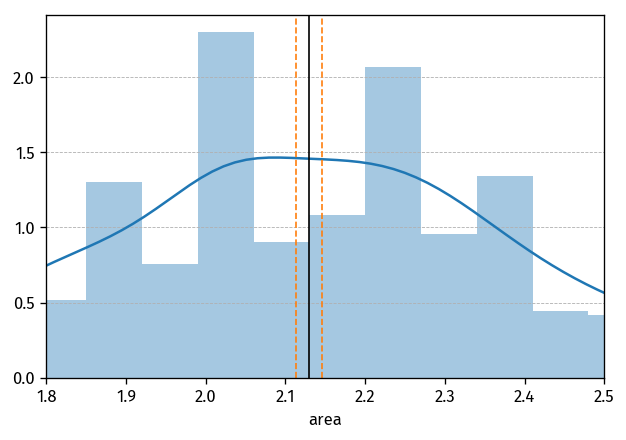

In [24]:
fig, ax = plt.subplots(dpi=120)
sns.distplot(a=results_df["area"], bins=20, ax=ax)
ax.axvline(x=results_df["area"].mean(), color="black", linestyle="-", linewidth=1)
ax.axvline(x=ci_df.loc[0, "mean"], color="tab:orange", linestyle="--", linewidth=1)
ax.axvline(x=ci_df.loc[1, "mean"], color="tab:orange", linestyle="--", linewidth=1)
ax.set_xlim([1.8, 2.5]);

#### 1,000 darts

In [25]:
results_df = multi_integration_sims(1000)
bootstrap_df = darts_bootstrap(results_df)
ci_df = confidence_intervals(bootstrap_df)

activity_results["num_darts"].append(1000)
activity_results["mean"].append(results_df["area"].mean())
activity_results["ci95_lower"].append(ci_df.loc[0, "mean"])
activity_results["ci95_upper"].append(ci_df.loc[1, "mean"])

/home/jglasbr2/.conda/envs/cds411-dev/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


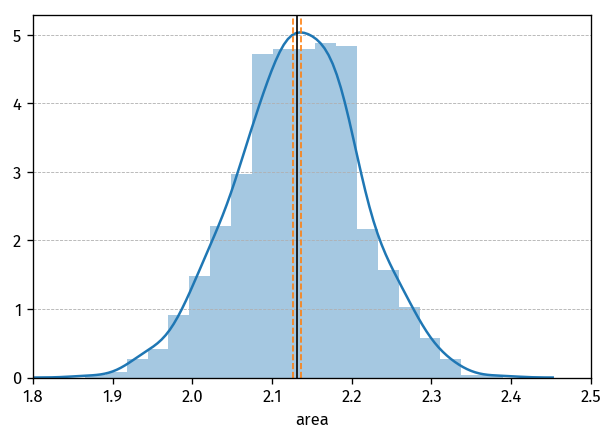

In [26]:
fig, ax = plt.subplots(dpi=120)
sns.distplot(a=results_df["area"], bins=20, ax=ax)
ax.axvline(x=results_df["area"].mean(), color="black", linestyle="-", linewidth=1)
ax.axvline(x=ci_df.loc[0, "mean"], color="tab:orange", linestyle="--", linewidth=1)
ax.axvline(x=ci_df.loc[1, "mean"], color="tab:orange", linestyle="--", linewidth=1)
ax.set_xlim([1.8, 2.5]);

#### 10,000 darts

In [27]:
results_df = multi_integration_sims(10000)
bootstrap_df = darts_bootstrap(results_df)
ci_df = confidence_intervals(bootstrap_df)

activity_results["num_darts"].append(10000)
activity_results["mean"].append(results_df["area"].mean())
activity_results["ci95_lower"].append(ci_df.loc[0, "mean"])
activity_results["ci95_upper"].append(ci_df.loc[1, "mean"])

/home/jglasbr2/.conda/envs/cds411-dev/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


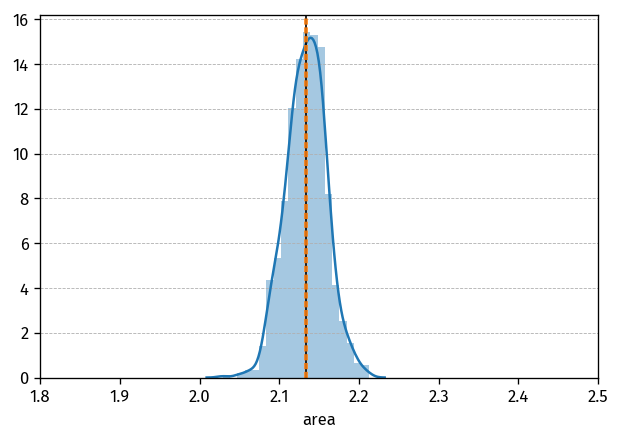

In [28]:
fig, ax = plt.subplots(dpi=120)
sns.distplot(a=results_df["area"], bins=20, ax=ax)
ax.axvline(x=results_df["area"].mean(), color="black", linestyle="-", linewidth=1)
ax.axvline(x=ci_df.loc[0, "mean"], color="tab:orange", linestyle="--", linewidth=1)
ax.axvline(x=ci_df.loc[1, "mean"], color="tab:orange", linestyle="--", linewidth=1)
ax.set_xlim([1.8, 2.5]);

#### 100,000 darts

In [29]:
results_df = multi_integration_sims(100000)
bootstrap_df = darts_bootstrap(results_df)
ci_df = confidence_intervals(bootstrap_df)

activity_results["num_darts"].append(100000)
activity_results["mean"].append(results_df["area"].mean())
activity_results["ci95_lower"].append(ci_df.loc[0, "mean"])
activity_results["ci95_upper"].append(ci_df.loc[1, "mean"])

/home/jglasbr2/.conda/envs/cds411-dev/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


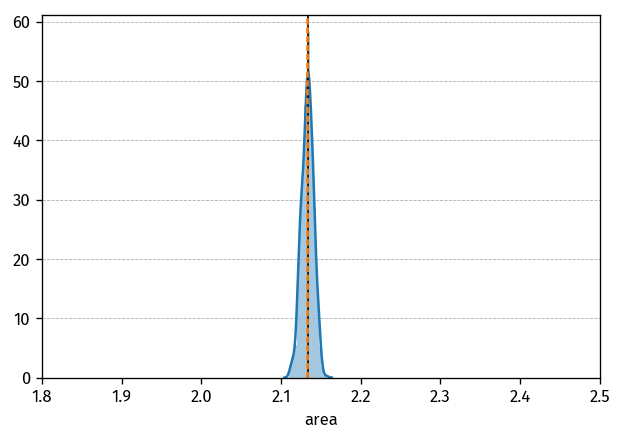

In [30]:
fig, ax = plt.subplots(dpi=120)
sns.distplot(a=results_df["area"], bins=20, ax=ax)
ax.axvline(x=results_df["area"].mean(), color="black", linestyle="-", linewidth=1)
ax.axvline(x=ci_df.loc[0, "mean"], color="tab:orange", linestyle="--", linewidth=1)
ax.axvline(x=ci_df.loc[1, "mean"], color="tab:orange", linestyle="--", linewidth=1)
ax.set_xlim([1.8, 2.5]);

#### 1,000,000 darts

In [31]:
results_df = multi_integration_sims(1000000)
bootstrap_df = darts_bootstrap(results_df)
ci_df = confidence_intervals(bootstrap_df)

activity_results["num_darts"].append(1000000)
activity_results["mean"].append(results_df["area"].mean())
activity_results["ci95_lower"].append(ci_df.loc[0, "mean"])
activity_results["ci95_upper"].append(ci_df.loc[1, "mean"])

/home/jglasbr2/.conda/envs/cds411-dev/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


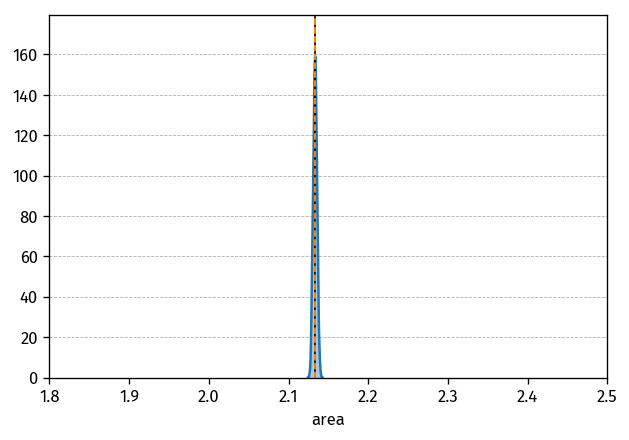

In [32]:
fig, ax = plt.subplots(dpi=120)
sns.distplot(a=results_df["area"], bins=20, ax=ax)
ax.axvline(x=results_df["area"].mean(), color="black", linestyle="-", linewidth=1)
ax.axvline(x=ci_df.loc[0, "mean"], color="tab:orange", linestyle="--", linewidth=1)
ax.axvline(x=ci_df.loc[1, "mean"], color="tab:orange", linestyle="--", linewidth=1)
ax.set_xlim([1.8, 2.5]);

#### Summary of activity results

If you complete this quickly, create a visualization that plots the mean estimated area for the different numbers of dart throws. Include error bars that represent the standard error of the mean. See the [class 19 Jupyter notebook](../class19/class19_notebook.ipynb) for a refresher on how to plot error bars.

In [33]:
activity_results_df = pd.DataFrame(activity_results)
activity_results_df["yerr_lower"] = np.abs(activity_results_df["mean"] - activity_results_df["ci95_lower"])
activity_results_df["yerr_upper"] = np.abs(activity_results_df["mean"] - activity_results_df["ci95_upper"])

The data frame summarizes the averages and standard errors for different number of dart throws.

In [34]:
activity_results_df

,num_darts,mean,ci95_lower,ci95_upper,yerr_lower,yerr_upper
0,100,2.130150,2.113849,2.146050,0.016301,0.015900
1,1000,2.131695,2.126675,2.136461,0.005020,0.004766
2,10000,2.133681,2.132144,2.135266,0.001537,0.001584
3,100000,2.133420,2.132952,2.133870,0.000468,0.000450
4,1000000,2.133335,2.133178,2.133486,0.000157,0.000151


Visualizing the results for different numbers of dart throws:

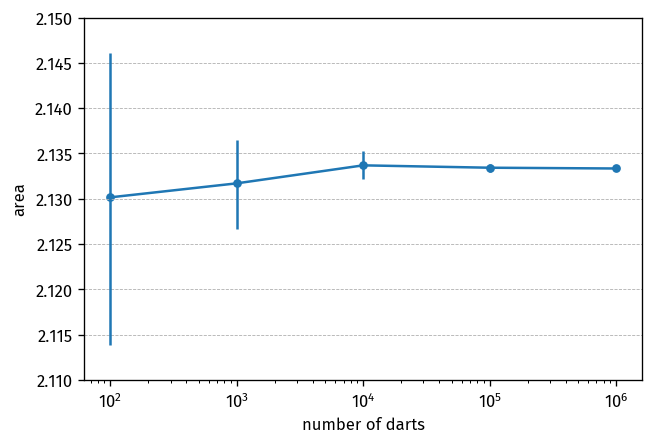

In [35]:
fig, ax = plt.subplots(dpi=120)
ax.set_xscale("log", nonposx='clip')
sns.scatterplot(x="num_darts", y="mean", data=activity_results_df, ax=ax)
ax.errorbar(
    x=activity_results_df["num_darts"],
    y=activity_results_df["mean"],
    yerr=[activity_results_df["yerr_lower"],
          activity_results_df["yerr_upper"]],
)
ax.set_ylim([2.11, 2.150])
ax.set_xlabel("number of darts")
ax.set_ylabel("area");

## Multiplicative Linear Congruential Method

The textbook introduces the following simple linear congruential random number generator that generates values between 0 and 10, inclusive:

\begin{equation}
r_{0}=10
\end{equation}
\begin{equation}
r_{n}=\left(7r_{n-1}+1\right)\text{ mod }11,\text{ for }n>0
\end{equation}

In [36]:
def my_random(seed, multiplier, increment, modulus):
    sequence = (multiplier * seed + increment) % modulus
    return sequence

In [37]:
my_random(10, 7, 1, 11)

5

In [38]:
my_random(5, 7, 1, 11)

3

### Sequence 1

In [39]:
my_seed = 10
my_multiplier = 2
my_increment = 0
my_modulus = 11

save_sequence = []
for i in range(20):
    random_out = my_random(my_seed, my_multiplier, my_increment, my_modulus)
    save_sequence.append(random_out)
    my_seed = random_out

In [40]:
print(save_sequence)

[9, 7, 3, 6, 1, 2, 4, 8, 5, 10, 9, 7, 3, 6, 1, 2, 4, 8, 5, 10]


### Sequence 2

In [41]:
my_seed = 15
my_multiplier = 16807
my_increment = 0
my_modulus = 2**31 - 1

save_sequence = []
for i in range(20):
    random_out = my_random(my_seed, my_multiplier, my_increment, my_modulus)
    save_sequence.append(random_out)
    my_seed = random_out

In [42]:
print(save_sequence)

[252105, 2089645088, 717430978, 1889252988, 2129248421, 610718139, 1515413160, 392926700, 406832375, 43794577, 1616048365, 1699186946, 997463616, 1113645630, 1722119805, 2030452016, 144398435, 247975935, 1613264365, 5655533]


### Sequence 3

In [43]:
my_seed = 200
my_multiplier = 16807
my_increment = 0
my_modulus = 2**31 - 1
generate_numbers = 1000000

save_sequence = []
for i in range(generate_numbers):
    random_out = my_random(my_seed, my_multiplier, my_increment, my_modulus)
    my_seed = random_out
    random_out = random_out / (2**31 - 2)
    save_sequence.append(random_out)
    
save_sequence = np.array(save_sequence)

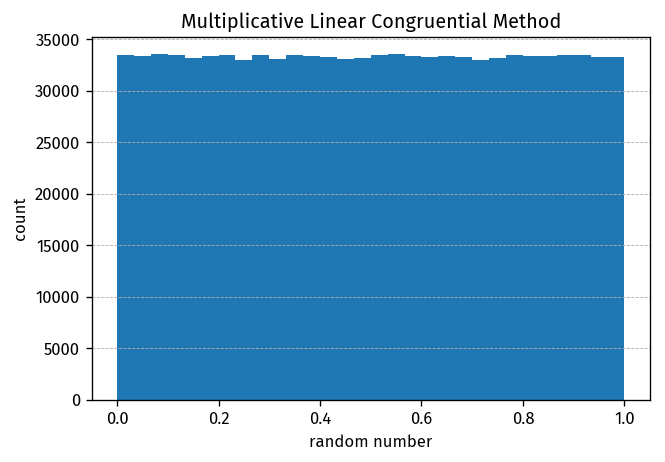

In [44]:
fig, ax = plt.subplots(dpi=120)
random_df = pd.DataFrame({"random_numbers": save_sequence})
sns.distplot(a=random_df["random_numbers"], bins=30, ax=ax, kde=False, hist_kws={"alpha": 1})
ax.set_xlabel("random number")
ax.set_ylabel("count")
ax.set_title("Multiplicative Linear Congruential Method");

# Random numbers from various distributions

## Distribution of numbers

*   Description of portion of times each possible outcome or each possible range of outcomes occurs on the average over many trials

## Uniform distribution

*   Just as likely to return value in any interval

*   In list of many random numbers, on the average each interval contains same number of generated values

## Discrete distribution

*   Distribution with discrete values

*   **Probability function** (or **density function** or **probability density function**)
    *   Returns probability of occurrence of particular argument value

## Discrete distribution

*   **To Generate Random Numbers in Discrete Distribution with Equal Probabilities for Each of *n* Events**
    *   Generate uniform random integer from a sequence of *n* integers, where each integer corresponds to an event

## Using `numpy`

There are two methods available in `numpy` for sampling integers from a uniform distribution.
There is `np.random.randint`, which let's you specify the integer range directly, and works like so:

In [45]:
np.random.randint(low=1, high=5, size=10)

array([2, 1, 3, 4, 1, 1, 1, 1, 2, 3])

And then there's `np.random.choice`, which is more general and allows you to randomly sample from an array-like list.
To replicate the above behavior, you would use the following inputs like so:

In [46]:
np.random.choice(a=[1, 2, 3, 4], size=10, replace=True, p=None)

array([1, 3, 3, 2, 1, 3, 1, 2, 4, 1])